### Importy bibliotek

In [ ]:
import os
import json
import string
# import morfeusz2
import pandas as pd
import itertools as it
import operator as op
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


1. Utworzenie korpusu dokumentów

In [ ]:
corpus_dir = "./literatura"
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
files = corpus.fileids()
files

2. Wstępne przygotowanie dokumentów

In [ ]:
documents = {}
for f in files:
    documents[f] = corpus.raw(f)
print(json.dumps(documents, indent=4, ensure_ascii=False))

In [ ]:
stoplist_file = open("./stopwords_pl.txt", "r", encoding="UTF-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

In [ ]:
def lemmatize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0,1))
    def disambiguate(group):
        pairs = ((len(descr), lemma)
                 for _, _, (_, lemma, descr, _, _, ) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

In [ ]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language='polish') if word not in stoplist])
print(json.dumps(documents, indent=4, ensure_ascii=False))

3. Utworzenie macierzy częstości

In [ ]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns = ['content']
docs

In [ ]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

4. Chmury tagów

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    max_words=5000,
    contour_width=3,
    contour_color='steelblue'
)
if not os.path.exists("./chmury"):
    os.mkdir("./chmury")
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(index.replace(".txt", ""))
    plt.savefig("./chmury/{}".format(index.replace(".txt", ".png")))


5. Topic modelling

In [68]:
if not os.path.exists("./tematy"):
    os.mkdir("./tematy")
def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f"./tematy/{title}.png")
    plt.close()

In [69]:
def plot_documents(model, counts, files_names, n_components, title):
  colors = ['forestgreen', 'lightskyblue', 'hotpink', 'turquoise', 'steelblue', 'crimson', 'seagreen', 'orange']
  docs_topics = pd.DataFrame(model.transform(counts), columns=[f"Topic {x}" for x in range(n_components)])
  docs_topics.index = [file_name.replace(".txt", "") for file_name in files_names]
  plt.figure(figsize=(7,4))
  left = [0] * len(docs_topics)
  for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, label=col, color = colors[i])
    left = [left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]
  plt.savefig(f"./tematy/{title}._docs.png")
  plt.close()

In [62]:
n_components = 6
feature_names = count_vectorizer.get_feature_names_out()
n_top_words = 20
subplots = (2,3)

In [70]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method='online',
    learning_offset=50,
    random_state=0
)
lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_words, "Tematy w modelu LDA", subplots)
plot_documents(lda, counts_tf, files, n_components,"Tematy w modelu LDA")

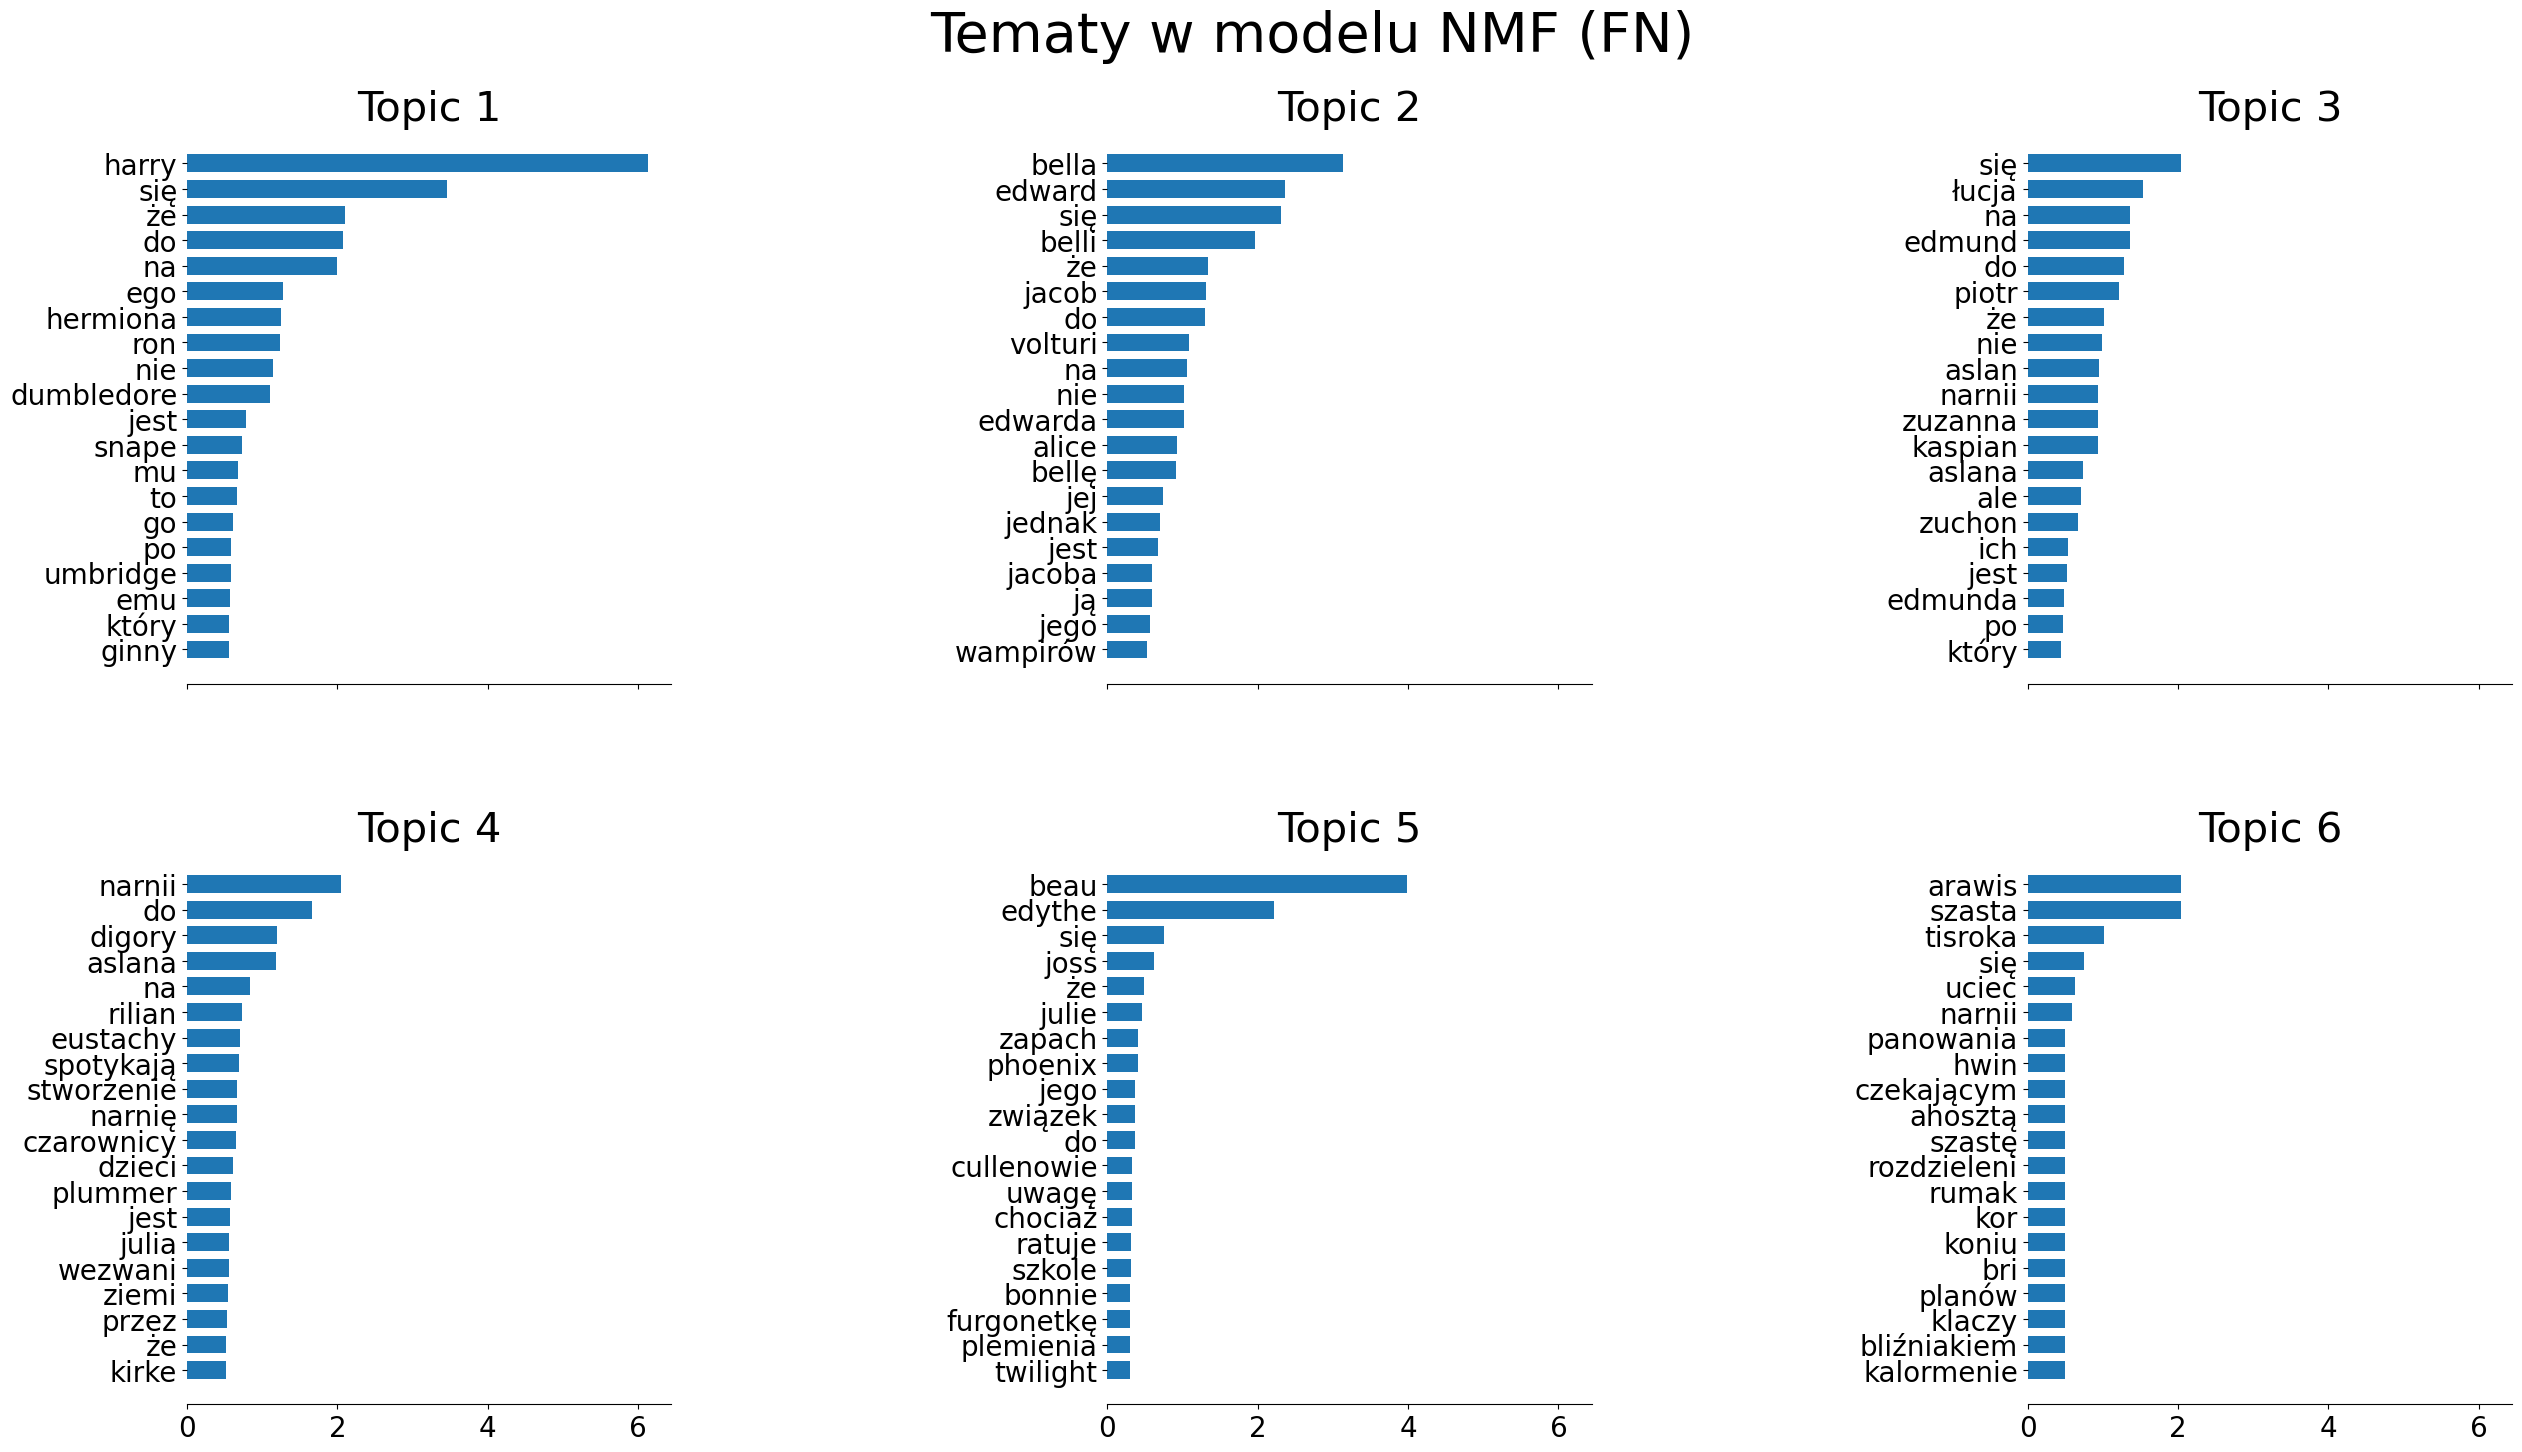

In [ ]:
nmf_fn = NMF(
    n_components=n_components,
    random_state=1,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_fn.fit(counts_tfidf)
plot_top_words(nmf_fn, feature_names, n_top_words, "Tematy w modelu NMF (FN)", subplots)
plot_documents(nmf_fn, counts_tfidf, files, n_components, "Tematy w modelu NMF (FN)" )

In [ ]:
nmf_kl = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_words, "Tematy w modelu NMF (KL)", subplots)